# CV Course Project: Assignment - Image Recognition

---

**Group:**
- Alumno 1:
- Alumno 2: Sukhorukova, Anastasia (anastasia.s@alumnos.upm.es)
- Alumno 3: Reyes Castro, Didier Yamil (didier.reyes.castro@alumnos.upm.es)

**Course:** Computer Vision (CV) - 2025/26

**Institution:** Polytechnic University of Madrid (UPM)

**Date:** January 2026

---

## Goals

The goals of the assignment are:
* Develop proficiency in using Tensorflow/Keras for training Neural Nets (NNs).
* Put into practice the acquired knowledge to optimize the parameters and architecture of a feedforward Neural Net (ffNN), in the context of an image recognition problem.
* Put into practice NNs specially conceived for analysing images. Design and optimize the parameters of a Convolutional Neural Net (CNN) to deal with previous task.
* Train popular architectures from scratch (e.g., GoogLeNet, VGG, ResNet, ...), and compare the results with the ones provided by their pre-trained versions using transfer learning.

Follow the link below to download the classification data set  “xview_recognition”: [https://drive.upm.es/s/2DDPE2zHw5dbM3G](https://drive.upm.es/s/2DDPE2zHw5dbM3G)

## 0 Setup and Data Loading

### 0.1 Install and Import Required Libraries

If using Google Colab, uncomment the following line to install the required packages.

In [1]:
# !pip install tensorflow numpy rasterio scikit-learn matplotlib keras

If using Conda, create a new environment and install the required packages:
```bash
conda create -n cv_project python tensorflow numpy rasterio scikit-learn matplotlib jupyterlab
conda activate cv_project
```

Loading the necessary libraries.

In [2]:
# Python libraries
import uuid
import warnings
import json
import os
import math

# External libraries
import numpy as np
import rasterio
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Rescaling, BatchNormalization, Dropout, LeakyReLU # type: ignore
from tensorflow.keras.optimizers import Adam, AdamW, SGD
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
from tensorflow.keras.callbacks import TerminateOnNaN, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


2025-10-10 13:03:43.434924: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-10 13:03:43.552175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760094223.582502    2448 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760094223.591315    2448 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-10 13:03:43.726854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Check if GPU is available for training the models.

In [3]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 0.2 Load the Dataset & Image Loader

Before loading the dataset, set the path to the folder containing the images.

In [4]:
IMAGES_PATH = '/mnt/c/Users/didie/Desktop/main/MUIA/CV/Labs/Image_Recognition/xview_recognition/'

In [5]:
class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1
        self.score = -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [6]:
categories = {0: 'Cargo plane', 1: 'Small car', 2: 'Bus', 3: 'Truck', 4: 'Motorboat', 5: 'Fishing vessel', 6: 'Dump truck', 7: 'Excavator', 8: 'Building', 9: 'Helipad', 10: 'Storage tank', 11: 'Shipping container', 12: 'Pylon'}

In [7]:
def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(IMAGES_PATH + filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

In [8]:
# Load database
json_file = IMAGES_PATH + 'xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [9]:
counts = dict.fromkeys(categories.values(), 0)
anns_dataset = []
for json_img, json_ann in zip(json_data['images'].values(), json_data['annotations'].values()):
    image = GenericImage(json_img['filename'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = json_ann['category_id']
    # Resampling strategy to reduce training time
    counts[obj.category] += 1
    image.add_object(obj)
    anns_dataset.append(image)
print(counts)

{'Cargo plane': 635, 'Small car': 3324, 'Bus': 1768, 'Truck': 2210, 'Motorboat': 1069, 'Fishing vessel': 706, 'Dump truck': 1236, 'Excavator': 789, 'Building': 3594, 'Helipad': 111, 'Storage tank': 1469, 'Shipping container': 1523, 'Pylon': 312}


In [10]:
def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

### 0.3 Setup

In [11]:
# Fix random seed for reproducibility
RANDOM_SEED = 42
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
set_seed(RANDOM_SEED)

# Number of categories for classification
NUM_CATEGORIES = len(categories)

### 0.4 Possible Architectures / Parameters to Tune

- Stratification of Split
- Normalisation of the input data (rescaling pixels from [0, 255] to [0, 1])
- Adam tuning: learning rate, beta 1, beta 2, epsilon, amsgrad
- Increase number of epochs
- Adding more Dense layers
- Change the activation functions of Dense layers: ReLU, leaky ReLU, ELU (which to choose for each layer?)
- Change loss function from Crossentropy to Focal Loss
- Weight Initialisation (HE initialisation)
- Use BatchNorm layers (but where? in all layers?)
- Dropout?, Early stopping?
- Increase batch size (although it could generalise worst but be parallelised) (also batch size being related to learning rate: learning*N/batch)
- Other advanced techniques seen in class: SGD with warm restarts, SAM

## 1 Model 0: Simple (and Bad) ffNN > Multinomial Logistic Regression Model

The following architecture is used as a starting point:
- Validation split: 10% (NO stratification)
- Input layer: 150,528 neurons (224x224x3) > Activation function: ReLU
- Output layer: 13 neurons (the categories to classify) > Activation function: Softmax
- Optimiser: Adam with learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0
- Loss function: Categorical Crossentropy

### 1.1 Setup

In [ ]:
anns_train, anns_valid = train_test_split(anns_dataset, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)
print('Number of training images: ' + str(len(anns_train)))
print('Number of validation images: ' + str(len(anns_valid)))

In [ ]:
print('Compiling the model...')

model = Sequential([
    Input(shape=(224, 224, 3)), # 224x224 images with 3 channels (RGB)
    Flatten(), # Flatten the 3D tensor to 1D
    Activation('relu'),
    Dense(NUM_CATEGORIES, activation='softmax') # Output layer with softmax activation
])

model.summary()

opt = Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-8, amsgrad=True, clipnorm=1.0)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

The following are helper functions that monitor the training process:
- **ModelCheckpoint:** Save the best model based on validation accuracy.
- **ReduceLROnPlateau:** Reduce learning rate when validation accuracy stops improving.
- **EarlyStopping:** Stop training when validation accuracy stops improving.
- **TerminateOnNaN:** Stop training if NaN loss is encountered.

In [ ]:
# Callbacks
model_checkpoint = ModelCheckpoint('model.keras', monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau('val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping('val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

Transforming the ImageObjects to actual image generators for training and validation.

In [ ]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in anns_train for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in anns_valid for obj in ann.objects]

# Generators
BATCH_SIZE = 16
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

### 1.2 Training

In [ ]:
print('Training model...')

EPOCHS = 20
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h = model.fit(train_generator, 
              steps_per_epoch=train_steps, 
              validation_data=valid_generator, 
              validation_steps=valid_steps, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h.history['val_accuracy']))
best_value = np.max(h.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

- Training time: ~ 108 minutes
- GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
- Best validation model: Epoch 15 - Validation accuracy: 0.3941

### 1.3 Validation
Compute validation metrics.

In [ ]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [ ]:
model.load_weights('model.keras')
y_true, y_pred = [], []
for ann in anns_valid:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [ ]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

### 1.4 Testing
Trying to improve the results provided in the competition.

In [ ]:
anns = []

for (dirpath, dirnames, filenames) in os.walk('/mnt/c/Users/didie/Desktop/main/MUIA/CV/Labs/Image_Recognition/xview_recognition/xview_test'):
    for filename in filenames:
        image = GenericImage(dirpath + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

In [ ]:
model.load_weights('model_5.keras')
predictions_data = {"images": {}, "annotations": {}}

i = 0

for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data

    if i == 0:
        print(image_data)
        i += 1

    # Load image
    print(ann.filename)
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)

## 2 Model Adjustments

The following architecture is used:
- Validation split: 10% (stratified)
- Input layer: The images are rescaled from [0, 255] to [0, 1]
- Two hidden layers:
  - Hidden layer 1: 256 neurons > He initialisation > Activation function: Leaky ReLU
  - Hidden layer 2: 128 neurons > He initialisation > Activation function: Leaky ReLU
- Batch Normalization after each hidden layer
- Dropout after each hidden layer
- Loss function: Focal Loss
- Optimiser: Adam with learning_rate=1e-3

Future:
- Modify current architecture: More neurons or more layers
- Increase number of epochs
- Increase batch size (could generalise worst)
- Try SAM OR SGD with warm restarts
- Modify current parameters: validation split size, not stratifying but shuffling data, Adam parameters, dropout rate, leaky ReLU slope, ...


### 2.1 Setup

In [12]:
train2, val2 = train_test_split(anns_dataset,
                                test_size=0.1, 
                                random_state=RANDOM_SEED, 
                                stratify=[obj.category for ann in anns_dataset for obj in ann.objects])
print('Number of training images: ' + str(len(train2)))
print('Number of validation images: ' + str(len(val2)))

Number of training images: 16871
Number of validation images: 1875


In [ ]:
#import numpy as np
#import matplotlib.pyplot as plt
#from collections import Counter

# 1. Extract the category labels from your datasets
#train_labels = [obj.category for ann in train2 for obj in ann.objects]
#valid_labels = [obj.category for ann in val2 for obj in ann.objects]

# 2. Count the occurrences of each category
#train_counts = Counter(train_labels)
#valid_counts = Counter(valid_labels)

# 3. Print the counts and proportions
#print("--- Training Set Proportions ---")
#for cat, count in sorted(train_counts.items()):
#    percentage = (count / len(train_labels)) * 100
#    print(f"{cat} | Count: {count:<5} | Percentage: {percentage:.2f}%")

#print("\n--- Validation Set Proportions ---")
#for cat, count in sorted(valid_counts.items()):
#    percentage = (count / len(valid_labels)) * 100
#    print(f"{cat} | Count: {count:<5} | Percentage: {percentage:.2f}%")

In [13]:
print('Compiling the model...')

model = Sequential([
    Input(shape=(224, 224, 3)), # 224x224 images with 3 channels (RGB)
    Rescaling(1./255), # Rescale pixel values to [0, 1]
    Flatten(), # Flatten the 3D tensor to 1D
    
    Dense(512, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),
    
    Dense(128, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(64, kernel_initializer='he_normal'),
    BatchNormalization(),
    LeakyReLU(negative_slope=0.1),
    Dropout(0.3),

    Dense(NUM_CATEGORIES, activation='softmax') # Output layer with softmax activation
])

model.summary()


lr_schedule = CosineDecayRestarts(
    initial_learning_rate=1e-3,
    first_decay_steps=1000
)

opt = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(optimizer=opt, loss='categorical_focal_crossentropy', metrics=['accuracy'])

Compiling the model...


I0000 00:00:1760094235.461499    2448 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1751 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 13)             │           845 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,148,429 (294.30 MB)

 Trainable params: 77,147,021 (294.29 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [14]:
# Callbacks
MODEL_NAME = 'model_7.keras'

model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='val_accuracy', verbose=1, save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=10, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience=40, verbose=1)
terminate = TerminateOnNaN()
callbacks = [model_checkpoint, reduce_lr, early_stop, terminate]

In [15]:
# Generate the list of objects from annotations
objs_train = [(ann.filename, obj) for ann in train2 for obj in ann.objects]
objs_valid = [(ann.filename, obj) for ann in val2 for obj in ann.objects]

# Generators
BATCH_SIZE = 32
train_generator = generator_images(objs_train, BATCH_SIZE, do_shuffle=True)
valid_generator = generator_images(objs_valid, BATCH_SIZE, do_shuffle=False)

### 2.2 Training

In [16]:
print('Training model...')

EPOCHS = 30
train_steps = math.ceil(len(objs_train)/BATCH_SIZE)
valid_steps = math.ceil(len(objs_valid)/BATCH_SIZE)

h1 = model.fit(train_generator, 
              steps_per_epoch=train_steps, 
              validation_data=valid_generator, 
              validation_steps=valid_steps, 
              epochs=EPOCHS, 
              callbacks=callbacks, 
              verbose=1)

# Best validation model
best_idx = int(np.argmax(h1.history['val_accuracy']))
best_value = np.max(h1.history['val_accuracy'])
print('Best validation model: epoch ' + str(best_idx+1), ' - val_accuracy ' + str(best_value))

Training model...
Epoch 1/30


I0000 00:00:1760094248.375244    2571 service.cc:148] XLA service 0x75020c001d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1760094248.375291    2571 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2025-10-10 13:04:08.458895: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1760094248.582668    2571 cuda_dnn.cc:529] Loaded cuDNN version 90101
2025-10-10 13:04:09.286936: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114', 188 bytes spill stores, 188 bytes spill loads

2025-10-10 13:04:09.288316: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

  1/528 ━━━━━━━━━━━━━━━━━━━━ 47:24 5s/step - accuracy: 0.0312 - loss: 0.7338

I0000 00:00:1760094252.242374    2571 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


527/528 ━━━━━━━━━━━━━━━━━━━━ 0s 805ms/step - accuracy: 0.1957 - loss: 0.5477

2025-10-10 13:11:16.460028: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114_0', 256 bytes spill stores, 256 bytes spill loads



528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 809ms/step - accuracy: 0.1958 - loss: 0.5476

2025-10-10 13:12:04.369605: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 16 bytes spill stores, 16 bytes spill loads

2025-10-10 13:12:04.483443: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96', 16 bytes spill stores, 16 bytes spill loads

2025-10-10 13:12:04.501932: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_96_0', 256 bytes spill stores, 256 bytes spill loads




Epoch 1: val_accuracy improved from None to 0.38613, saving model to model_7.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 480s 901ms/step - accuracy: 0.2483 - loss: 0.4905 - val_accuracy: 0.3861 - val_loss: 0.3679 - learning_rate: 4.5607e-04
Epoch 2/30
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 583ms/step - accuracy: 0.3268 - loss: 0.4182
Epoch 2: val_accuracy did not improve from 0.38613
528/528 ━━━━━━━━━━━━━━━━━━━━ 341s 648ms/step - accuracy: 0.3310 - loss: 0.4108 - val_accuracy: 0.3493 - val_loss: 0.3777 - learning_rate: 9.9807e-04
Epoch 3/30
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3414 - loss: 0.3967
Epoch 3: val_accuracy improved from 0.38613 to 0.40373, saving model to model_7.keras
528/528 ━━━━━━━━━━━━━━━━━━━━ 307s 583ms/step - accuracy: 0.3407 - loss: 0.3941 - val_accuracy: 0.4037 - val_loss: 0.3300 - learning_rate: 8.0397e-04
Epoch 4/30
528/528 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.3492 - loss: 0.3733
Epoch 4: val_accuracy improved from 0.40373 to 0.44000, saving model

- Training time: ~158  minutes
- GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
- Best validation model: Epoch 23 - Validation accuracy: 0.5397

### 2.3 Validation

In [17]:
def draw_confusion_matrix(cm, categories):
    # Draw confusion matrix
    fig = plt.figure(figsize=[6.4*pow(len(categories), 0.5), 4.8*pow(len(categories), 0.5)])
    ax = fig.add_subplot(111)
    cm = cm.astype('float') / np.maximum(cm.sum(axis=1)[:, np.newaxis], np.finfo(np.float64).eps)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.colormaps['Blues'])
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=list(categories.values()), yticklabels=list(categories.values()), ylabel='Annotation', xlabel='Prediction')
    # Rotate the tick labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], '.2f'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black", fontsize=int(20-pow(len(categories), 0.5)))
    fig.tight_layout()
    plt.show()

In [18]:
model.load_weights(MODEL_NAME)
y_true, y_pred = [], []
for ann in val2:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)

2025-10-10 15:49:28.848718: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4', 12 bytes spill stores, 12 bytes spill loads

2025-10-10 15:49:28.968058: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4_0', 24 bytes spill stores, 24 bytes spill loads



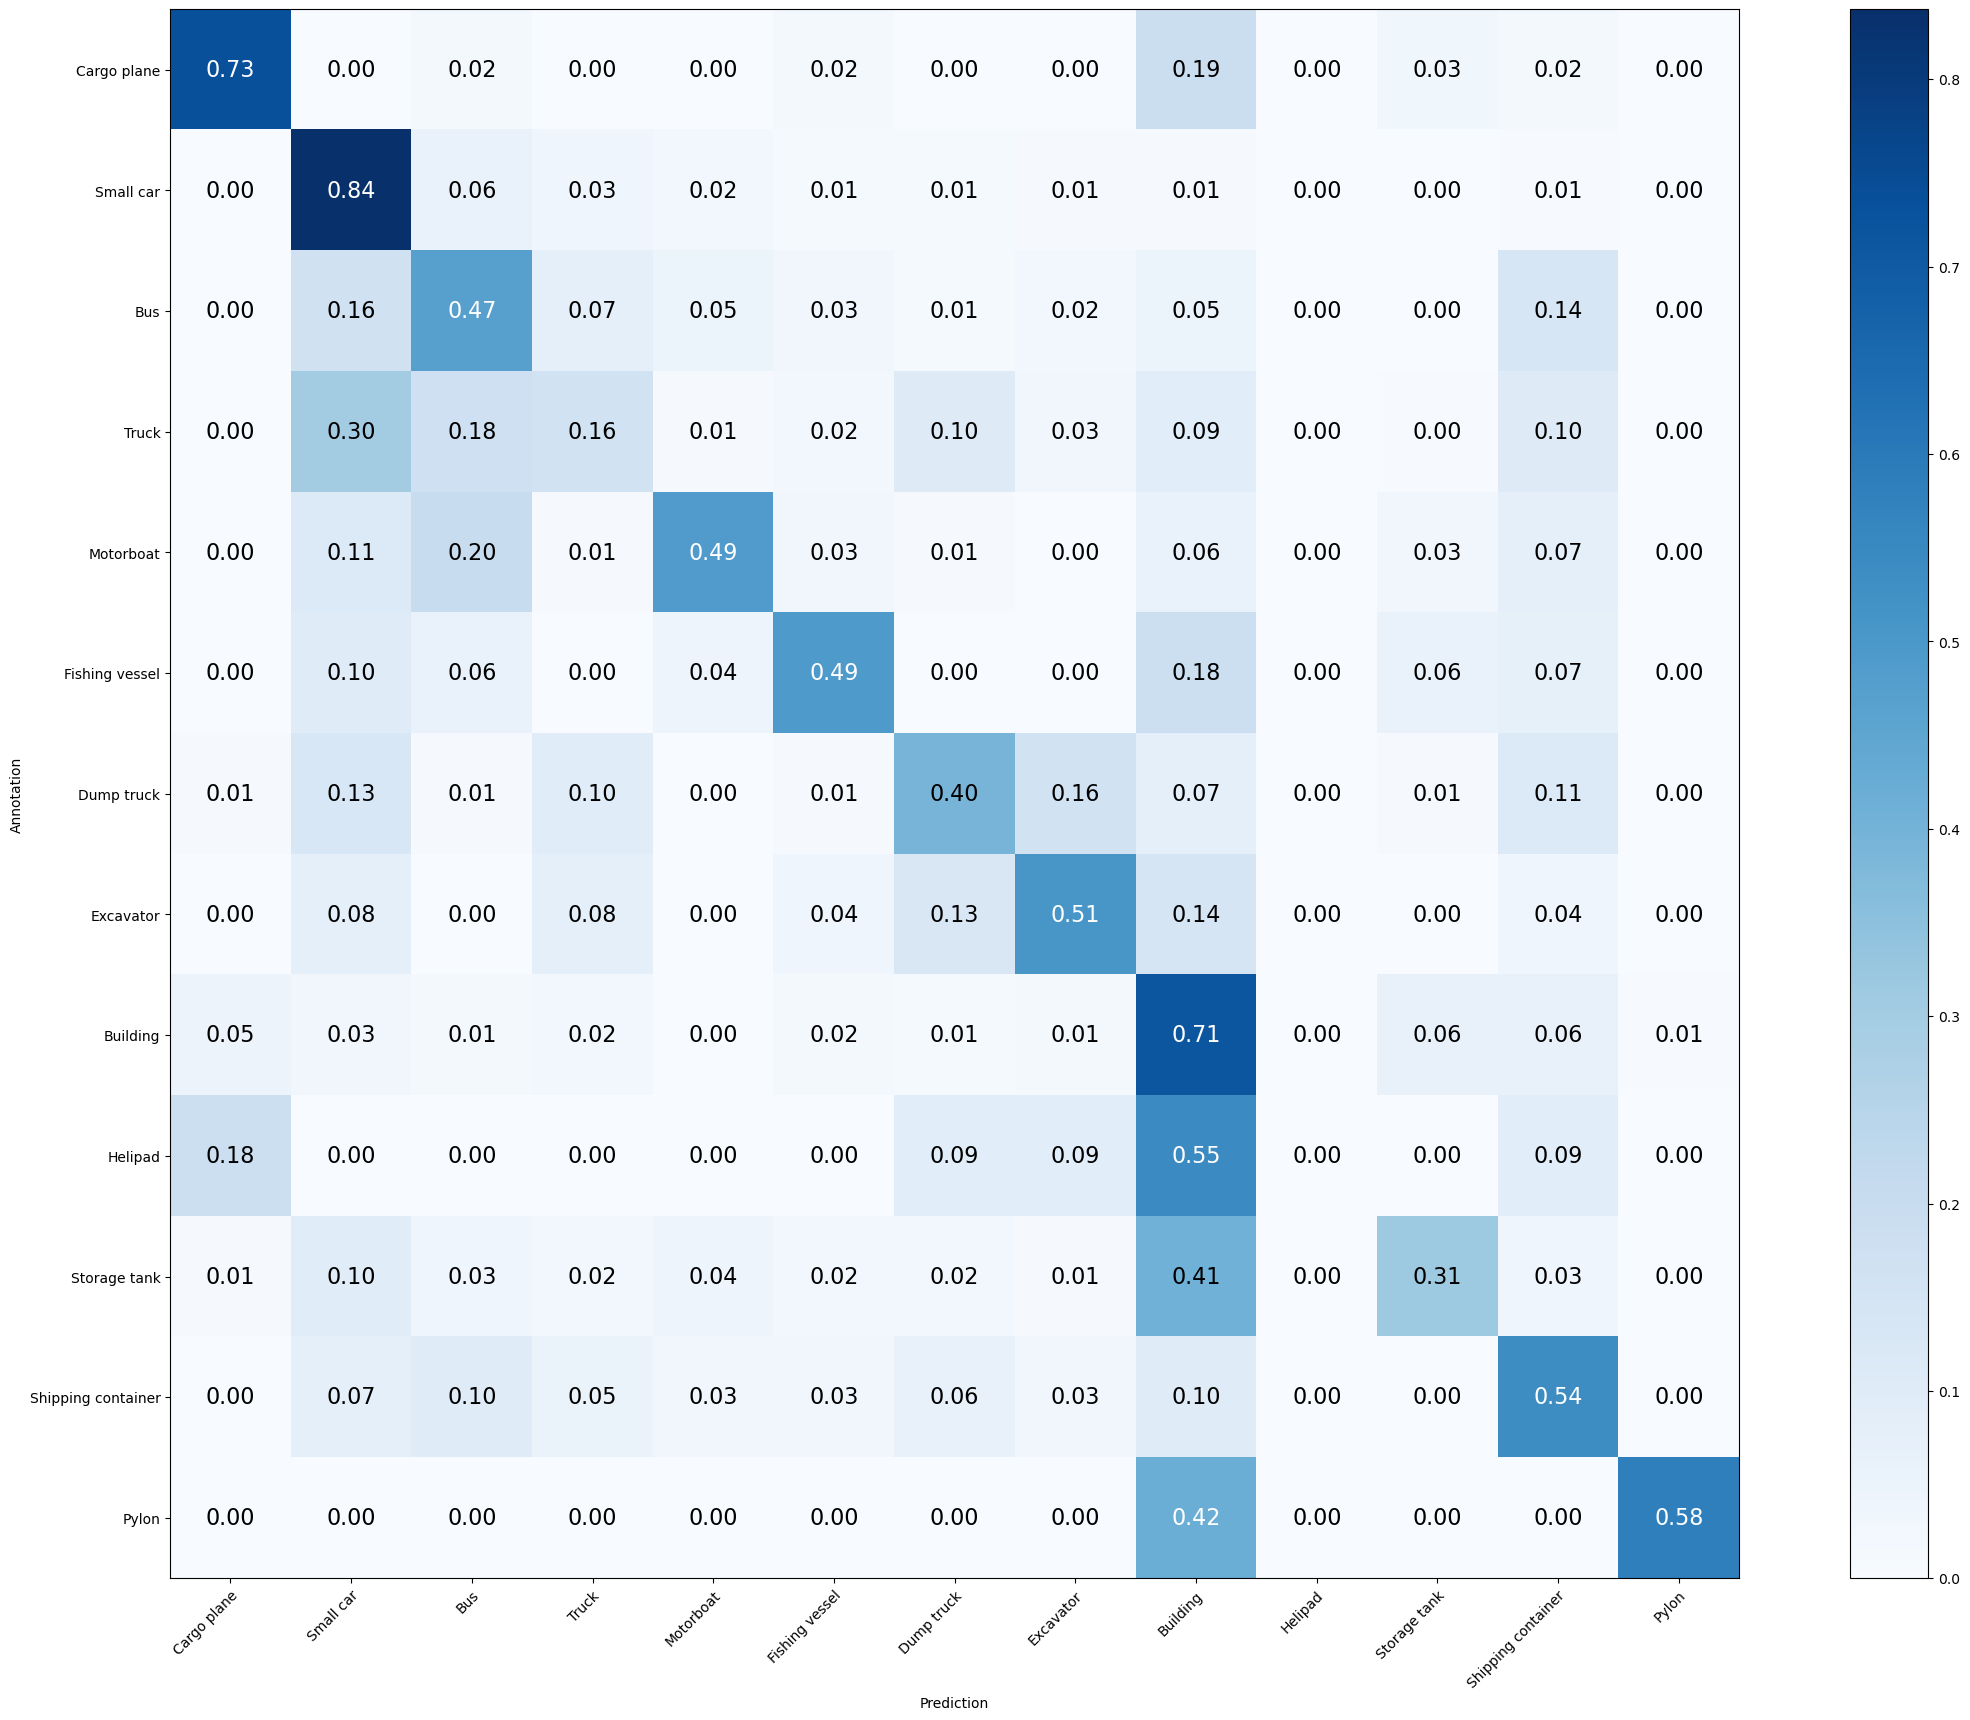

In [19]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(categories.values()))
draw_confusion_matrix(cm, categories)

In [20]:
# Compute the accuracy
correct_samples_class = np.diag(cm).astype(float)
total_samples_class = np.sum(cm, axis=1).astype(float)
total_predicts_class = np.sum(cm, axis=0).astype(float)
print('Mean Accuracy: %.3f%%' % (np.sum(correct_samples_class) / np.sum(total_samples_class) * 100))
acc = correct_samples_class / np.maximum(total_samples_class, np.finfo(np.float64).eps)
print('Mean Recall: %.3f%%' % (acc.mean() * 100))
acc = correct_samples_class / np.maximum(total_predicts_class, np.finfo(np.float64).eps)
print('Mean Precision: %.3f%%' % (acc.mean() * 100))
for idx in range(len(categories)):
    # True/False Positives (TP/FP) refer to the number of predicted positives that were correct/incorrect.
    # True/False Negatives (TN/FN) refer to the number of predicted negatives that were correct/incorrect.
    tp = cm[idx, idx]
    fp = sum(cm[:, idx]) - tp
    fn = sum(cm[idx, :]) - tp
    tn = sum(np.delete(sum(cm) - cm[idx, :], idx))
    # True Positive Rate: proportion of real positive cases that were correctly predicted as positive.
    recall = tp / np.maximum(tp+fn, np.finfo(np.float64).eps)
    # Precision: proportion of predicted positive cases that were truly real positives.
    precision = tp / np.maximum(tp+fp, np.finfo(np.float64).eps)
    # True Negative Rate: proportion of real negative cases that were correctly predicted as negative.
    specificity = tn / np.maximum(tn+fp, np.finfo(np.float64).eps)
    # Dice coefficient refers to two times the intersection of two sets divided by the sum of their areas.
    # Dice = 2 |A∩B| / (|A|+|B|) = 2 TP / (2 TP + FP + FN)
    f1_score = 2 * ((precision * recall) / np.maximum(precision+recall, np.finfo(np.float64).eps))
    print('> %s: Recall: %.3f%% Precision: %.3f%% Specificity: %.3f%% Dice: %.3f%%' % (list(categories.values())[idx], recall*100, precision*100, specificity*100, f1_score*100))

Mean Accuracy: 54.507%
Mean Recall: 47.924%
Mean Precision: 51.210%
> Cargo plane: Recall: 73.438% Precision: 69.118% Specificity: 98.840% Dice: 71.212%
> Small car: Recall: 83.735% Precision: 61.915% Specificity: 88.918% Dice: 71.191%
> Bus: Recall: 46.893% Precision: 43.005% Specificity: 93.522% Dice: 44.865%
> Truck: Recall: 16.290% Precision: 36.735% Specificity: 96.252% Dice: 22.571%
> Motorboat: Recall: 48.598% Precision: 61.176% Specificity: 98.133% Dice: 54.167%
> Fishing vessel: Recall: 49.296% Precision: 49.296% Specificity: 98.004% Dice: 49.296%
> Dump truck: Recall: 39.516% Precision: 46.226% Specificity: 96.745% Dice: 42.609%
> Excavator: Recall: 50.633% Precision: 47.619% Specificity: 97.550% Dice: 49.080%
> Building: Recall: 71.309% Precision: 59.259% Specificity: 88.391% Dice: 64.728%
> Helipad: Recall: 0.000% Precision: 0.000% Specificity: 100.000% Dice: 0.000%
> Storage tank: Recall: 31.293% Precision: 58.228% Specificity: 98.090% Dice: 40.708%
> Shipping container: R

### 2.4 Testing

In [ ]:
anns = []
i = 0
for (dirpath, dirnames, filenames) in os.walk('/mnt/c/Users/didie/Desktop/main/MUIA/CV/Labs/Image_Recognition/xview_recognition/xview_test/'):
    for filename in filenames:
        image = GenericImage(dirpath + '/' + filename)
        image.tile = np.array([0, 0, 224, 224])
        obj = GenericObject()
        obj.bb = (0, 0, 224, 224)
        obj.category = dirpath[dirpath.rfind('/')+1:]
        image.add_object(obj)
        anns.append(image)
print('Number of testing images: ' + str(len(anns)))

In [ ]:
model.load_weights(MODEL_NAME)
predictions_data = {"images": {}, "annotations": {}}

for idx, ann in enumerate(anns):
    image_data = {"image_id": ann.filename.split('/')[-1], "filename": ann.filename, "width": int(ann.tile[2]), "height": int(ann.tile[3])}
    predictions_data["images"][idx] = image_data
    # Load image
    image = load_geoimage("/".join(ann.filename.split('/')[-3:]))
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        predictions = model.predict(warped_image, verbose=0)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        annotation_data = {"image_id": ann.filename.split('/')[-1], "category_id": pred_category, "bbox": [int(x) for x in obj_pred.bb]}
        predictions_data["annotations"][idx] = annotation_data

In [ ]:
with open("prediction.json", "w") as outfile:
    json.dump(predictions_data, outfile)

### 2.5 Log of Changes and Results

- Model 0 > Model 1

It seems like the model is performing worse (0.2176) than the previous one (0.36)  and almost always predicting "small car" for every image. Next steps: Decrease learning rate (1e-4)

- Model 1 > Model 2

The model performance has improved significantly (0.5093 of accuracy). Let's now try to add BatchNorm layers and Dropout to see if we can improve it even more.

- Model 2 > Model 3

The model performance has improved a little bit more (0.5530 of accuracy). The advantages of BatchNorm are that it allows for higher learning rates, so let's try increase back to 1e-3 and see if we can improve it even more.

- Model 3 > Model 4

The performance has improved slightly (0.5589) but the training time has decreased (110 min to 100 min). Let's now try to change the activation functions to Leaky ReLU (default: 0.3 negative slope) and see if we can improve it even more.

- Model 4 > Model 5

The performance was 0.5440 with 98 minutes, slightly worse than before. As there is class imbalance, let's try to change the loss function from Crossentropy to Focal Loss. Also, let's try to decrease the negative slope of Leaky ReLU from 0.3 (default) to 0.1.

- Model 5

The performance has improved a little bit more (0.56) from Model 4 with a training time of 99 minutes.

- Model 6

Added a smaller dense layer at the end (64 neurons). Change Adam to AdamW with weight decay of 1e-4 and MORE epochs > DID NOT obtained a better result than previous model. Adding more layers did not help at all.

- Model 7

Model 5 with AdamW and weight decay of 1e-4 and MORE epochs. Have a slight increase in accuracy 0.5744 and also, samples more difficult to classify are being classified better. Although on Test set, the accuracy have not improved so much.

- Model 8

Model 5 with AdamW, MORE epochs, less learning rate and less batch size. Had the same accuracy as Model 7 but training time was longer (158min vs 148min)

**TODO: ASK DIDIER FOR IMAGES ABOUT THESE RESULTS FOR POTENTIAL PRESENTATION!!**